# [Projet 6: Catégorisez automatiquement des questions](https://openclassrooms.com/fr/projects/categorisez-automatiquement-des-questions)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

Data exporter (StackExchange): [here](https://data.stackexchange.com/stackoverflow/query/new).  
My minimal SQL query:
```
SELECT
   Id,Body,Title,Tags
FROM
   Posts
WHERE
   Id < 5000 and Body<>'' and Title<>'' and Tags <>''
```

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [186]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
from scipy.sparse import hstack

import matplotlib.pyplot as plt
%matplotlib inline

Some info and uses for [BeautifulSoup](https://pypi.org/project/beautifulsoup4/): [here](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python),

In [2]:
from bs4 import BeautifulSoup # conda install beautifulsoup4

Some info and uses for [NLTK](https://pypi.org/project/nltk/): [here](http://www.nltk.org/book/),

In [3]:
import nltk
#nltk.download('punkt')

In [113]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
from Pkg.helper import basicHTMLTextCleaner, basicTagTextCleaner # needs correct working directory

### Data

In [6]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [7]:
filename = 'QueryResults_light.csv'
df = pd.read_csv(pathToDataDir+filename,index_col='Id')

In [8]:
n,p = df.shape
k = .8
df_train,df_test = df.iloc[:int(k*n),:].copy(),df.iloc[int(k*n):,:].copy()

In [10]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(408, 3) (102, 3)


,Body,Title,Tags
Id,,,
944,<p>I'm maintaining a .NET 1.1 application and ...,Unhandled Exception Handler in .NET 1.1,<c#><.net><exception><exception-handling>
419,<p>Part of my everyday work is maintaining and...,Unload a COM control when working in VB6 IDE,<com><vb6>
1401,<p>I have a custom validation function in Java...,ASP.Net Custom Client-Side Validation,<asp.net><javascript><validation>
3319,<p>How can I set the CSS background color of a...,CSS background color in JavaScript,<javascript><css>
3894,<p>Given the constraint of only using T-Sql in...,T-Sql Remove Decimal Point From Money Data Type,<sql-server><tsql><sql-server-2005>


### Basic text cleaning

In [13]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [117]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemer = nltk.PorterStemmer()

df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)

In [26]:
df_train.sample(50)

,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
3157,<p>In an application that heavily relies on <c...,.htaccess directives to *not* redirect certain...,<apache><.htaccess><mod-rewrite>,applic heavili reli htaccess rewriterul pretty...,htaccess direct redirect certain url,<apache><.htaccess><mod-rewrite>
3021,<p>One of the topics that seems to come up reg...,What is recursion and when should I use it?,<recursion><computer-science>,one topic seem come regularli mail list onlin ...,recurs use,<recursion><computer-science>
3839,<p>I'm trying out the following query:</p>\n\n...,How do I Concatenate entire result sets in MySQL?,<mysql><sql><union>,tri follow queri select b c tabl field like qu...,concaten entir result set mysql,<mysql><sql><union>
3976,<p>I have a Prolite LED sign that I like to se...,Programmatically talking to a Serial Port in O...,<python><linux><macos><serial-port>,prolit led sign like set show scroll search qu...,programmat talk serial port os x linux,<python><linux><macos><serial-port>
1376,<p>I need the name of the current logged in us...,Get the current logged in OS user in Adobe Air,<flex><air>,need name current log user air flex applic app...,get current log os user adob air,<flex><air>
4,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,want use track bar chang form opac code decim ...,convert decim doubl,<c#><floating-point><type-conversion><double><...
2482,<p>With the rise of multicore CPUs on the desk...,What are some good resources for learning thre...,<multithreading><language-agnostic><concurrency>,rise multicor cpu desktop multithread skill be...,good resourc learn thread program,<multithreading><language-agnostic><concurrency>
3903,<p>Since the WMI class Win32_OperatingSystem o...,Is this a good way to determine OS Architecture?,<c#><windows><registry>,sinc wmi class win32_operatingsystem includ os...,good way determin os architectur,<c#><windows><registry>
3512,"<p>I'm using MSVE, and I have my own tiles I'm...",Searching directories for tons of files?,<c#><directory><file-management>,use msve tile display layer top problem ton ne...,search directori ton file,<c#><directory><file-management>


### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [173]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
V_body = 20 # 500
count_body = CountVectorizer(analyzer = "word",   # entities to be counted
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])
vocab_body = count_body.vocabulary_

V_title = 5 # 100
count_title = CountVectorizer(analyzer = "word",   # entities to be counted
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])
vocab_title = count_title.vocabulary_

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [175]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [177]:
body2_train[0,:].toarray()

array([[ 0.29885271,  0.56936868,  0.32352746,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.2775814 ,  0.        ,  0.        ,  0.        ,  0.33831547,
         0.        ,  0.25881107,  0.        ,  0.47259325,  0.        ]])

In [178]:
title2_train[0,:].toarray()

array([[ 0.,  0.,  0.,  0.,  0.]])

*Target tags:*

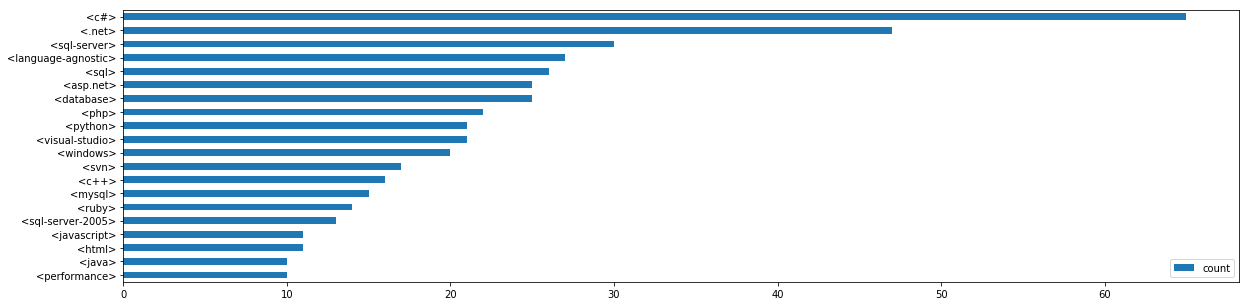

In [180]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
V_tag = 20 # NB (after viewing the plots): a looot of tags appear only once
count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # otherwise, treats tags as words
                            max_features = V_tag) 

count_tag.fit(df_train['Tags_clean'])
vocab_tag = count_tag.vocabulary_

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
for t,i in vocab_tag.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,5))

In [182]:
tag_train[0,:].toarray()

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [191]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*NEXT: handle cases when some rows do not have selected words/tags...*

### Cleaned data

In [11]:
name,ext = os.path.splitext(filename)

c = ('Body_clean','Title_clean','Tags_clean')
df.loc[:,c].to_csv(os.path.join(pathToDataDir,name+'_clean'+ext),index=True)